# Build a Multimodal AI Shopping Agent with Voyage AI and Pixeltable

**Best-in-class embeddings and rerankers powering an intelligent product assistant**

Modern e-commerce platforms need more than keyword search—they need AI that understands customer intent. Queries like "comfortable shoes for standing all day" or "gift ideas for a tech enthusiast" require semantic understanding, not string matching.

In this tutorial, we'll build an **AI-powered shopping agent** that combines:

- **[Voyage AI](https://voyageai.com)**: State-of-the-art embedding models (voyage-3.5) and rerankers (rerank-2.5) purpose-built for search and retrieval
- **[Pixeltable](https://pixeltable.com)**: Declarative AI data infrastructure for embeddings, tool calling, and agentic pipelines

Using real Amazon product data, we'll create:

1. 🔍 **Semantic Product Search**: Multi-column embeddings with weighted similarity
2. 🎯 **Two-Stage Retrieval**: Fast embedding search + precise reranking
3. 📊 **Declarative Pipelines**: Multiple search strategies as computed columns
4. 🤖 **AI Shopping Agent**: LLM that orchestrates search and lookup tools

### Prerequisites

- A Voyage AI API key ([get one free](https://www.voyageai.com/))
- An OpenAI API key (for the agent)
- Basic familiarity with Python


## Setup

First, let's install the required packages and configure our environment.


In [1]:
%pip install -qU pixeltable voyageai openai jinja2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import getpass

if 'VOYAGE_API_KEY' not in os.environ:
    os.environ['VOYAGE_API_KEY'] = getpass.getpass('Enter your Voyage AI API key: ')

In [3]:
import pixeltable as pxt
from pixeltable.functions import voyageai

# Create a fresh workspace for this demo
pxt.drop_dir('ecommerce_search', force=True)
pxt.create_dir('ecommerce_search')

/opt/miniconda3/envs/pixeltable/lib/python3.11/site-packages/pixeltable/env.py:492: UserWarning: Progress reporting is disabled because ipywidgets is not installed. To fix this, run: `pip install ipywidgets`
  warnings.warn(


Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'ecommerce_search'.


## Load Amazon Product Data

We'll use a pre-processed subset of the [Amazon Product Dataset 2020](https://huggingface.co/datasets/calmgoose/amazon-product-data-2020), which contains real product listings with rich metadata including:

- Product names and descriptions
- Categories and specifications
- Pricing information
- **One image URL per row** (the original dataset had multiple images pipe-separated; we've split them for easier processing)

The dataset contains ~1,800 rows from 500 products, with each product having 1-7 images.


In [4]:
# Pre-processed Amazon product dataset URL
# Note: Update URL to pixeltable/pixeltable after PR is merged
DATASET_URL = 'https://raw.githubusercontent.com/pierrebrunelle/pixeltable/feature/voyageai-ecommerce-search-notebook/docs/resources/amazon_products_with_images.parquet'

In [5]:
# Preview: load with pandas to see the data
import pandas as pd
df = pd.read_parquet(DATASET_URL)

### Import into Pixeltable

Now let's import this dataset into Pixeltable. Pixeltable can directly ingest PyArrow tables via `create_table(source=...)`.


Created table 'products'.
Inserted 1779 rows with 10 errors across 2 columns (products.None, products.Image) in 19.49 s (91.28 rows/s)


Uniq_Id,Product_Name,Category,Selling_Price,About_Product,Image,image_idx
4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fiberglass Longboard Complete","Sports & Outdoors | Outdoor Recreation | Skates, Skateboards & Scooters | Skateboarding | Standard Skateboards & Longboards | Longboards",\$237.68,"Make sure this fits by entering your model number. | RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern that’s second to none. Pumping & carving have never been so satisfying! Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you won’t believe. These boards combine fiberglass, epoxy, HD plastic and b ...... spired by the hills, waves, beaches & mountains all around our headquarters in the Northwest | BEST IN THE WORLD: DB was founded out of sheer love of longboarding with a mission to create the best custom longboards in the world, to do it sustainably, & to treat customers & employees like family | BEYOND COMPARE: Try our skateboards & accessories if you've tried similar products by Sector 9, Landyachtz, Arbor, Loaded, Globe, Orangatang, Hawgs, Powell-Peralta, Blood Orange, Caliber or Gullwing",,0
4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fiberglass Longboard Complete","Sports & Outdoors | Outdoor Recreation | Skates, Skateboards & Scooters | Skateboarding | Standard Skateboards & Longboards | Longboards",\$237.68,"Make sure this fits by entering your model number. | RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern that’s second to none. Pumping & carving have never been so satisfying! Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you won’t believe. These boards combine fiberglass, epoxy, HD plastic and b ...... spired by the hills, waves, beaches & mountains all around our headquarters in the Northwest | BEST IN THE WORLD: DB was founded out of sheer love of longboarding with a mission to create the best custom longboards in the world, to do it sustainably, & to treat customers & employees like family | BEYOND COMPARE: Try our skateboards & accessories if you've tried similar products by Sector 9, Landyachtz, Arbor, Loaded, Globe, Orangatang, Hawgs, Powell-Peralta, Blood Orange, Caliber or Gullwing",,1
4c69b61db1fc16e7013b43fc926e502d,"DB Longboards CoreFlex Crossbow 41"" Bamboo Fiberglass Longboard Complete","Sports & Outdoors | Outdoor Recreation | Skates, Skateboards & Scooters | Skateboarding | Standard Skateboards & Longboards | Longboards",\$237.68,"Make sure this fits by entering your model number. | RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern that’s second to none. Pumping & carving have never been so satisfying! Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you won’t believe. These boards combine fiberglass, epoxy, HD plastic and b ...... spired by the hills, waves, beaches & mountains all around our headquarters in the Northwest | BEST IN THE WORLD: DB was founded out of sheer love of longboarding with a mission to create the best custom longboards in the world, to do it sustainably, & to treat customers & employees like family | BEYOND COMPARE: Try our skateboards & accessories if you've tried similar products by Sector 9, Landyachtz, Arbor, Loaded, Globe, Orangatang, Hawgs, Powell-Peralta, Blood Orange, Caliber or Gullwing",,2

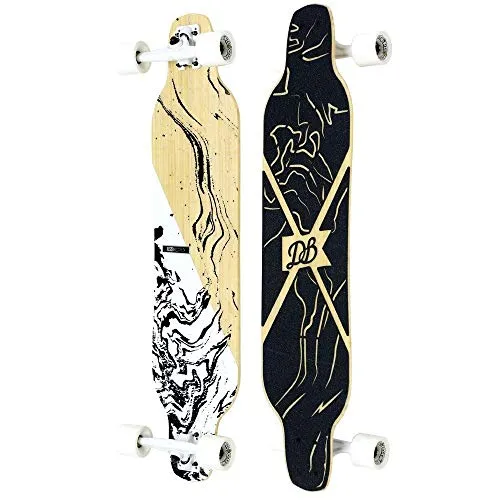
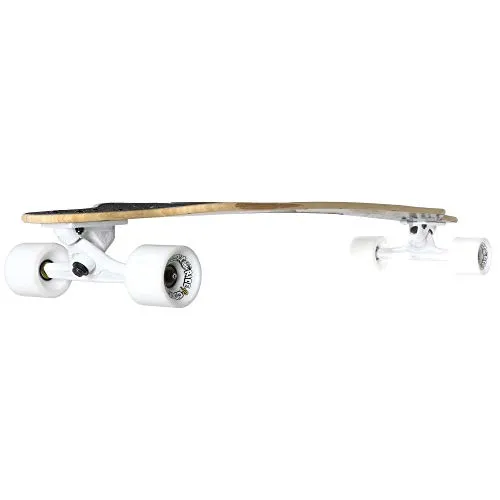
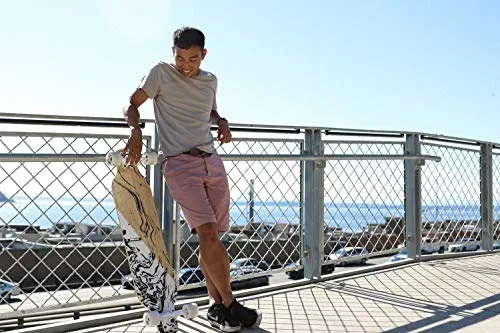

In [6]:
# Import the DataFrame into Pixeltable
# schema_overrides: explicitly type string columns and treat Image URLs as images
# on_error='ignore' skips rows where image URLs return 404 (some Amazon URLs expire)
products = pxt.create_table(
    'ecommerce_search.products',
    source=df,
    schema_overrides={
        'Uniq_Id': pxt.String,
        'Product_Name': pxt.String,
        'Category': pxt.String,
        'Selling_Price': pxt.String,
        'About_Product': pxt.String,
        'Image': pxt.Image,
    },
    on_error='ignore'
)

products.head(3)

## Multi-Column Embedding Strategy

Instead of combining all product fields into a single text, we'll create **separate embedding indexes** for each searchable column. This approach offers several advantages:

- **Flexible weighting**: Combine results from different columns with custom weights
- **Column-specific queries**: Search only product names, or only descriptions
- **Better relevance**: Each embedding captures the semantic meaning of its specific field


In [7]:
# Define the embedding function once for reuse
# The .using() syntax fixes the model parameter, creating a specialized embedding function
embed_fn = voyageai.embeddings.using(model='voyage-3.5', input_type='document')

# Add embedding indexes for each searchable text column
products.add_embedding_index('Product_Name', embedding=embed_fn)
products.add_embedding_index('Category', embedding=embed_fn)
products.add_embedding_index('About_Product', embedding=embed_fn)

In [8]:
# View the table structure - note the embedding indexes
products

table 'ecommerce_search.products'

    Column Name    Type Computed With
        Uniq_Id  String              
   Product_Name  String              
       Category  String              
  Selling_Price  String              
  About_Product  String              
          Image   Image              
      image_idx     Int              

 Index Name         Column  Metric                                          Embedding
       idx7   Product_Name  cosine  embeddings(Product_Name, model='voyage-3.5', i...
       idx8       Category  cosine  embeddings(Category, model='voyage-3.5', input...
       idx9  About_Product  cosine  embeddings(About_Product, model='voyage-3.5', ...

## Semantic Product Search with Query Functions

With embedding indexes on multiple columns, we can create **query functions** that combine similarity scores with configurable weights. Query functions (`@pxt.query`) are declarative—they can be used as computed columns that execute automatically when data is inserted.


In [9]:
@pxt.query
def weighted_search(
    query_text: str, 
    limit: int = 5,
    name_weight: float = 0.4,
    category_weight: float = 0.2,
    description_weight: float = 0.4
):
    """
    Search products using weighted similarity across multiple columns.
    
    As a @pxt.query function, this can be:
    - Called directly: weighted_search('toys', limit=10)
    - Used in computed columns with different weight configurations
    """
    name_sim = products['Product_Name'].similarity(string=query_text)
    category_sim = products['Category'].similarity(string=query_text)
    description_sim = products['About_Product'].similarity(string=query_text)
    
    combined_score = (
        name_weight * name_sim + 
        category_weight * category_sim + 
        description_weight * description_sim
    )
    
    return (
        products
        .order_by(combined_score, asc=False)
        .limit(limit)
        .select(
            products['Product_Name'],
            products['Category'],
            products['Selling_Price'],
            score=combined_score
        )
    )


### Direct Query Execution

Query functions can be called directly for interactive exploration:


In [10]:
# Natural language query with default weights
weighted_search("fun games for kids birthday party")


weighted_search('fun games for kids birthday party')

In [11]:
# Adjust weights to prioritize product names
weighted_search("educational toys", name_weight=0.7, category_weight=0.1, description_weight=0.2)

weighted_search('educational toys', name_weight=0.7, category_weight=0.1, description_weight=0.2)

### Declarative Search with Computed Columns

The real power of `@pxt.query` functions is using them as **computed columns**. We can create a searches table with multiple weighting strategies—each computed automatically when queries are inserted:

In [12]:
# Create a searches table with multiple weighting strategies as computed columns
searches = pxt.create_table(
    'ecommerce_search.searches',
    {'query': pxt.String}
)

# Strategy 1: Balanced (default weights - good general-purpose search)
searches.add_computed_column(
    balanced=weighted_search(searches.query)
)

# Strategy 2: Name-focused (prioritizes exact product name matches)
searches.add_computed_column(
    name_focused=weighted_search(
        searches.query,
        name_weight=0.7, category_weight=0.1, description_weight=0.2
    )
)

# Strategy 3: Description-focused (finds products by feature descriptions)
searches.add_computed_column(
    description_focused=weighted_search(
        searches.query,
        name_weight=0.2, category_weight=0.1, description_weight=0.7
    )
)

Created table 'searches'.
Added 0 column values with 0 errors in 0.00 s
Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [13]:
# Insert a query - all three strategies compute automatically!
searches.insert([{'query': 'durable outdoor toys for active kids'}])

Inserted 1 row with 0 errors in 1.58 s (0.63 rows/s)


1 row inserted.

In [14]:
# Compare results: Balanced strategy
searches.select(searches.query, searches.balanced).collect()

query,balanced
durable outdoor toys for active kids,"[{""score"": null, ""Category"": ""Toys & Games | Puzzles"", ""Product_Name"": ""Awesome Paw Patrol Bundle of 3 Pieces"", ""Selling_Price"": ""\$8.52""}, {""score"": null, ""Category"": ""Clothing, Shoes & Jewelry | Costumes & Accessories | Women | Costumes & Cosplay Apparel | Costumes"", ""Product_Name"": ""Rubie's Costume Womens Police Costume"", ""Selling_Price"": ""\$16.03 - \$24.79""}, {""score"": null, ""Category"": ""Sports & Outdoors | Sports & Fitness | Leisure Sports & Game Room | Outdoor Games & Activities | Balls | Playground Balls"", ""Product_Name"": ""American Educational Vinyl Clever Catch Elementary Science Insects Ball, 24\"" Diameter"", ""Selling_Price"": ""\$17.40""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Gowi Toys Austria Police Van with Police Play Figures"", ""Selling_Price"": ""\$11.16""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Disney Rapunzel Acrylic Key Ring, Multicolor"", ""Selling_Price"": ""\$3.33""}]"


In [15]:
# Compare results: Name-focused strategy (different top results!)
searches.select(searches.query, searches.name_focused).collect()

query,name_focused
durable outdoor toys for active kids,"[{""score"": null, ""Category"": ""Toys & Games | Puzzles"", ""Product_Name"": ""Awesome Paw Patrol Bundle of 3 Pieces"", ""Selling_Price"": ""\$8.52""}, {""score"": null, ""Category"": ""Clothing, Shoes & Jewelry | Costumes & Accessories | Women | Costumes & Cosplay Apparel | Costumes"", ""Product_Name"": ""Rubie's Costume Womens Police Costume"", ""Selling_Price"": ""\$16.03 - \$24.79""}, {""score"": null, ""Category"": ""Sports & Outdoors | Sports & Fitness | Leisure Sports & Game Room | Outdoor Games & Activities | Balls | Playground Balls"", ""Product_Name"": ""American Educational Vinyl Clever Catch Elementary Science Insects Ball, 24\"" Diameter"", ""Selling_Price"": ""\$17.40""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Gowi Toys Austria Police Van with Police Play Figures"", ""Selling_Price"": ""\$11.16""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Disney Rapunzel Acrylic Key Ring, Multicolor"", ""Selling_Price"": ""\$3.33""}]"


## Boost Relevance with Voyage AI Reranking

While semantic search is powerful, we can further improve result quality using Voyage AI's **rerank-2.5** model. The two-stage retrieval pattern:

1. **First stage**: Use embeddings to quickly retrieve candidates (top 15)
2. **Second stage**: Use the reranker to precisely score and reorder results

Let's add reranking as another computed column to our searches table:


In [16]:
# First, we need candidates for reranking (reuse weighted_search with more results)
searches.add_computed_column(
    candidates=weighted_search(searches.query, limit=15)
)

# Add reranking using Voyage AI's rerank-2.5 model
# Reranks the embedding search results for improved precision
searches.add_computed_column(
    reranked=voyageai.rerank(
        searches.query,
        searches.candidates['About_Product'],  # Rerank based on descriptions
        model='rerank-2.5',
        top_k=5
    )
)


Added 1 column value with 0 errors in 0.59 s (1.68 rows/s)
Added 1 column value with 0 errors in 0.01 s (75.30 rows/s)


1 row updated.

In [17]:
# View the complete searches table - now with 5 computed columns!
# For each query: 3 weighting strategies + candidates + reranked results
searches


table 'ecommerce_search.searches'

          Column Name    Type                                      Computed With
                query  String                                                   
             balanced    Json                             weighted_search(query)
         name_focused    Json  weighted_search(query, name_weight=0.7, catego...
  description_focused    Json  weighted_search(query, name_weight=0.2, catego...
           candidates    Json                   weighted_search(query, limit=15)
             reranked    Json  rerank(query, candidates.About_Product, model=...

In [18]:
# The query we inserted earlier now has reranked results too!
# Compare: balanced embedding search vs reranked
searches.select(
    searches.query,
    searches.balanced,
    searches.reranked
).collect()

query,balanced,reranked
durable outdoor toys for active kids,"[{""score"": null, ""Category"": ""Toys & Games | Puzzles"", ""Product_Name"": ""Awesome Paw Patrol Bundle of 3 Pieces"", ""Selling_Price"": ""\$8.52""}, {""score"": null, ""Category"": ""Clothing, Shoes & Jewelry | Costumes & Accessories | Women | Costumes & Cosplay Apparel | Costumes"", ""Product_Name"": ""Rubie's Costume Womens Police Costume"", ""Selling_Price"": ""\$16.03 - \$24.79""}, {""score"": null, ""Category"": ""Sports & Outdoors | Sports & Fitness | Leisure Sports & Game Room | Outdoor Games & Activities | Balls | Playground Balls"", ""Product_Name"": ""American Educational Vinyl Clever Catch Elementary Science Insects Ball, 24\"" Diameter"", ""Selling_Price"": ""\$17.40""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Gowi Toys Austria Police Van with Police Play Figures"", ""Selling_Price"": ""\$11.16""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Disney Rapunzel Acrylic Key Ring, Multicolor"", ""Selling_Price"": ""\$3.33""}]",None


In [19]:
# Insert another query to see the full pipeline in action
searches.insert([{'query': 'safe educational toys for toddlers'}])


Inserted 1 row with 0 errors in 2.15 s (0.47 rows/s)


1 row inserted.

### Compare Embedding Search vs. Reranked Results

The reranker often surfaces more relevant results by considering the full query-document relationship:


In [20]:
# View embedding results (balanced strategy) vs reranked results
searches.select(
    searches.query,
    embedding_top_5=searches.balanced,
    reranked_top_5=searches.reranked['results']
).where(searches.query == 'safe educational toys for toddlers').collect()


query,embedding_top_5,reranked_top_5
safe educational toys for toddlers,"[{""score"": null, ""Category"": ""Toys & Games | Puzzles"", ""Product_Name"": ""Awesome Paw Patrol Bundle of 3 Pieces"", ""Selling_Price"": ""\$8.52""}, {""score"": null, ""Category"": ""Clothing, Shoes & Jewelry | Costumes & Accessories | Women | Costumes & Cosplay Apparel | Costumes"", ""Product_Name"": ""Rubie's Costume Womens Police Costume"", ""Selling_Price"": ""\$16.03 - \$24.79""}, {""score"": null, ""Category"": ""Sports & Outdoors | Sports & Fitness | Leisure Sports & Game Room | Outdoor Games & Activities | Balls | Playground Balls"", ""Product_Name"": ""American Educational Vinyl Clever Catch Elementary Science Insects Ball, 24\"" Diameter"", ""Selling_Price"": ""\$17.40""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Gowi Toys Austria Police Van with Police Play Figures"", ""Selling_Price"": ""\$11.16""}, {""score"": null, ""Category"": """", ""Product_Name"": ""Disney Rapunzel Acrylic Key Ring, Multicolor"", ""Selling_Price"": ""\$3.33""}]",None


In [21]:
# View all queries and their reranked results
searches.select(searches.query, searches.reranked).collect()


query,reranked
durable outdoor toys for active kids,None
safe educational toys for toddlers,None


## Incremental Updates: Adding New Products

One of Pixeltable's key strengths is handling incremental updates. When new products are added to the catalog, embeddings are computed automatically—no need to reprocess the entire dataset.


In [22]:
# Add new products - embeddings for all three indexes are computed automatically!
new_products = [
    {
        'Uniq_Id': 'new_001',
        'Product_Name': 'Ultimate STEM Building Kit - 500 Pieces',
        'Category': 'Toys & Games | Building Toys | Building Sets',
        'About_Product': 'Educational building set with 500 pieces for ages 6+. Includes gears, motors, and instruction booklet for 50 projects. Develops problem-solving and engineering skills.',
        'Selling_Price': '$49.99',
        'Image': None,  # Use None for no image, not empty string
        'image_idx': 0
    },
    {
        'Uniq_Id': 'new_002', 
        'Product_Name': 'Outdoor Adventure Binoculars for Kids',
        'Category': 'Toys & Games | Sports & Outdoor Play | Exploration Toys',
        'About_Product': 'Kid-friendly binoculars with 8x magnification, rubber grip, and neck strap. Perfect for bird watching, camping, and nature exploration. Shockproof design.',
        'Selling_Price': '$24.99',
        'Image': None,  # Use None for no image, not empty string
        'image_idx': 0
    }
]

products.insert(new_products)


Inserted 2 rows with 0 errors in 0.76 s (2.64 rows/s)


2 rows inserted.

In [23]:
# Search should now find the new products
weighted_search("STEM toys for kids who like to build things")


weighted_search('STEM toys for kids who like to build things')

## Agentic Search: LLM-Powered Product Assistant

Now let's combine everything into an **agentic pipeline** where an LLM decides which tools to use:

- **Semantic search** (`weighted_search`): Find products by meaning
- **Image search** (`search_product_images`): Find products by visual similarity  
- **Exact lookup** (`get_product_by_id`): Get specific product details by ID

The LLM orchestrates these tools to answer complex questions and returns **both text and images**.

In [24]:
# Create an exact product lookup using retrieval_udf
# This queries by product ID for precise lookups
get_product_by_id = pxt.retrieval_udf(
    products,
    name='get_product_by_id',
    description='Look up a specific product by its unique ID (Uniq_Id)',
    parameters=['Uniq_Id'],
    limit=1
)

In [ ]:
# Add image search capability using Voyage AI's multimodal embeddings
from pixeltable.functions import image as pxt_image

# Add Voyage AI multimodal embedding index on the Image column
# voyage-multimodal-3 embeds both text AND images in the same space!
products.add_embedding_index(
    'Image',
    embedding=voyageai.multimodal_embed.using(model='voyage-multimodal-3', input_type='document'),
    if_exists='ignore'
)

In [ ]:
# Create image search query using Voyage AI multimodal embeddings
@pxt.query
def search_product_images(query_text: str, limit: int = 3):
    """Search for product images using Voyage AI's voyage-multimodal-3.
    Text and images are in the same embedding space, enabling text-to-image search.
    Returns base64 encoded images for direct display."""
    sim = products.Image.similarity(query_text)
    return (
        products
        .where(sim > 0.2)  # Filter by similarity threshold
        .order_by(sim, asc=False)
        .limit(limit)
        .select(
            products.Product_Name,
            products.Selling_Price,
            # Encode image as base64 for direct display
            encoded_image=pxt_image.b64_encode(
                pxt_image.resize(products.Image, size=(224, 224)),
                'png'
            ),
            similarity=sim
        )
    )

In [25]:
# No need for a wrapper UDF - @pxt.query functions can be used directly as tools!
# weighted_search is already defined above and can be passed to pxt.tools()

In [ ]:
# Bundle all tools for LLM use
# @pxt.query functions and retrieval_udf work directly with pxt.tools()!
product_tools = pxt.tools(
    weighted_search,        # Semantic text search
    search_product_images,  # Visual similarity search (returns base64 images)
    get_product_by_id       # Exact lookup by ID
)

In [27]:
# Set up OpenAI for the agent (or use Anthropic, etc.)
if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter your OpenAI API key: ')

from pixeltable.functions import openai

In [28]:
# Create the agent table with tool-calling pipeline
agent = pxt.create_table(
    'ecommerce_search.agent',
    {'question': pxt.String}
)

# System prompt for the product assistant
SYSTEM_PROMPT = """You are a helpful e-commerce product assistant. You have access to three tools:
1. weighted_search: Find products by description, features, or category (semantic text search)
2. search_product_images: Find products by visual similarity - use when user asks to "show" products or wants images
3. get_product_by_id: Look up specific products by their unique ID

When users want to see products visually, use search_product_images. Be concise and helpful."""

# LLM decides which tools to call
agent.add_computed_column(
    llm_response=openai.chat_completions(
        messages=[
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': agent.question}
        ],
        model='gpt-4o-mini',
        tools=product_tools
    )
)

# Automatically execute the tool calls
agent.add_computed_column(
    tool_results=openai.invoke_tools(product_tools, agent.llm_response)
)

Created table 'agent'.
Added 0 column values with 0 errors in 0.00 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [ ]:
# UDF to assemble the final prompt with tool results (text only for LLM)
@pxt.udf
def assemble_answer_prompt(question: str, tool_results: dict) -> list[dict]:
    """Combine the original question and tool results into a prompt for final answer.
    Extracts text info from results; images are handled separately."""
    results_text = []
    for tool_name, outputs in (tool_results or {}).items():
        if outputs is None:
            continue  # Skip tools that weren't called
        for output in outputs:
            if output is None:
                continue
            # For image search results, just include product name/price (not base64)
            if tool_name == 'search_product_images' and isinstance(output, dict):
                name = output.get('Product_Name', 'Unknown')
                price = output.get('Selling_Price', 'N/A')
                results_text.append(f"[Image Result]: {name} - {price}")
            else:
                results_text.append(f"[{tool_name}]: {output}")
    
    context = "\n".join(results_text) if results_text else "No tool results available."
    
    return [
        {'role': 'system', 'content': 'You are a helpful product assistant. Use the tool results to answer the question concisely. Mention that images are shown below your response when image results are present.'},
        {'role': 'user', 'content': f"Question: {question}\n\nTool Results:\n{context}\n\nPlease provide a helpful answer based on the tool results."}
    ]

# UDF to extract images from tool results
@pxt.udf
def extract_images_from_results(tool_results: dict) -> list[dict]:
    """Extract base64 encoded images from search_product_images results."""
    images = []
    if not tool_results:
        return images
    
    image_results = tool_results.get('search_product_images')
    if image_results:
        for result in image_results:
            if result and isinstance(result, dict) and 'encoded_image' in result:
                images.append({
                    'product_name': result.get('Product_Name', 'Unknown'),
                    'price': result.get('Selling_Price', 'N/A'),
                    'encoded_image': result['encoded_image']
                })
    return images

# Generate final answer using tool results
agent.add_computed_column(
    answer_prompt=assemble_answer_prompt(agent.question, agent.tool_results)
)

agent.add_computed_column(
    answer=openai.chat_completions(
        messages=agent.answer_prompt,
        model='gpt-4o-mini'
    )['choices'][0]['message']['content']
)

# Extract images separately for display
agent.add_computed_column(
    image_results=extract_images_from_results(agent.tool_results)
)

Added 0 column values with 0 errors in 0.01 s
Added 0 column values with 0 errors in 0.01 s


No rows affected.

In [ ]:
# Test the agent with different types of questions - including one that requests images!
test_questions = [
    {'question': 'What educational toys do you have for kids who like building?'},
    {'question': 'Show me some colorful toys for toddlers'},  # This should trigger image search
    {'question': 'Tell me about product new_001'},
]

agent.insert(test_questions)

Inserted 3 rows with 0 errors in 12.42 s (0.24 rows/s)


3 rows inserted.

In [31]:
# View the agent's answers
agent.select(agent.question, agent.answer).collect()

question,answer
Tell me about product new_001,"The product **Ultimate STEM Building Kit - 500 Pieces** is priced at **\$49.99** and falls under the category of **Toys & Games**, specifically **Building Toys** and **Building Sets**. This educational building set is designed for children aged 6 and up, featuring **500 pieces** that include gears, motors, and an instruction booklet. It allows users to create **50 different projects**, emphasizing the development of problem-solving and engineering skills."
What educational toys do you have for kids who like building?,"While I don't have specific tool results to refer to, I can suggest several popular educational toys for kids who enjoy building: 1. **LEGO Sets** - Offering a wide range of sets for various age groups and interests, LEGO fosters creativity and fine motor skills. 2. **Magna-Tiles** - These colorful magnetic tiles encourage spatial awareness and creativity as children can build various structures. 3. **K'NEX** - A versatile construction toy that uses rods and connectors, perfect for older ...... plastic building blocks help younger kids develop motor skills and understand basic engineering concepts. 5. **Brio Builder Sets** - Combines building with interactive play and encourages problem-solving and creativity. 6. **Tinkertoy** - A classic construction set that helps kids learn about structures and balance while encouraging imaginative play. These toys not only provide hours of entertainment but also promote critical thinking, spatial reasoning, and creativity in young builders."
I need outdoor toys for active children. What do you recommend?,"For active children, here are some great outdoor toys to consider: 1. **Bicycles** - A classic choice for outdoor play, promoting exercise and coordination. 2. **Skateboards or scooters** - Great for developing balance and agility. 3. **Jump ropes** - Simple yet effective for improving coordination and cardiovascular fitness. 4. **Frisbees** - Fun for throwing and catching, perfect for group play. 5. **Kites** - Flying kites can be both exhilarating and a lesson in understanding wind dynami ...... fun game that encourages active play and competitiveness. 8. **Outdoor playground equipment** - Includes swings, slides, and climbing structures for endless active play. 9. **Water balloons or squirt guns** - Great for warm-weather fun and active water play. 10. **Obstacle courses** - Sets of cones, tunnels, and hurdles that can be set up for physical challenges. These toys not only entertain but also help develop physical skills and encourage teamwork and social interaction among children."


In [ ]:
# See answers and any retrieved images
# The agent returns both text answers AND images when visual search is triggered
agent.select(
    agent.question,
    agent.answer,
    agent.image_results  # Contains base64 encoded product images
).collect()

question,tool_results,answer
Tell me about product new_001,"{""weighted_search"": null, ""get_product_by_id"": [[{""Image"": null, ""Uniq_Id"": ""new_001"", ""Category"": ""Toys & Games | Building Toys | Building Sets"", ""image_idx"": 0, ""Product_Name"": ""Ultimate STEM Building Kit - 500 Pieces"", ""About_Product"": ""Educational building set with 500 pieces for ages 6+. Includes gears, motors, and instruction booklet for 50 projects. Develops problem-solving and engineering skills."", ""Selling_Price"": ""\$49.99""}]]}","The product **Ultimate STEM Building Kit - 500 Pieces** is priced at **\$49.99** and falls under the category of **Toys & Games**, specifically **Building Toys** and **Building Sets**. This educational building set is designed for children aged 6 and up, featuring **500 pieces** that include gears, motors, and an instruction booklet. It allows users to create **50 different projects**, emphasizing the development of problem-solving and engineering skills."
What educational toys do you have for kids who like building?,"{""weighted_search"": [null], ""get_product_by_id"": null}","While I don't have specific tool results to refer to, I can suggest several popular educational toys for kids who enjoy building: 1. **LEGO Sets** - Offering a wide range of sets for various age groups and interests, LEGO fosters creativity and fine motor skills. 2. **Magna-Tiles** - These colorful magnetic tiles encourage spatial awareness and creativity as children can build various structures. 3. **K'NEX** - A versatile construction toy that uses rods and connectors, perfect for older ...... plastic building blocks help younger kids develop motor skills and understand basic engineering concepts. 5. **Brio Builder Sets** - Combines building with interactive play and encourages problem-solving and creativity. 6. **Tinkertoy** - A classic construction set that helps kids learn about structures and balance while encouraging imaginative play. These toys not only provide hours of entertainment but also promote critical thinking, spatial reasoning, and creativity in young builders."
I need outdoor toys for active children. What do you recommend?,"{""weighted_search"": [null], ""get_product_by_id"": null}","For active children, here are some great outdoor toys to consider: 1. **Bicycles** - A classic choice for outdoor play, promoting exercise and coordination. 2. **Skateboards or scooters** - Great for developing balance and agility. 3. **Jump ropes** - Simple yet effective for improving coordination and cardiovascular fitness. 4. **Frisbees** - Fun for throwing and catching, perfect for group play. 5. **Kites** - Flying kites can be both exhilarating and a lesson in understanding wind dynami ...... fun game that encourages active play and competitiveness. 8. **Outdoor playground equipment** - Includes swings, slides, and climbing structures for endless active play. 9. **Water balloons or squirt guns** - Great for warm-weather fun and active water play. 10. **Obstacle courses** - Sets of cones, tunnels, and hurdles that can be set up for physical challenges. These toys not only entertain but also help develop physical skills and encourage teamwork and social interaction among children."


In [ ]:
# Display product images retrieved by the agent
from IPython.display import HTML, display

# Get results for the "Show me" question (should have images)
results = agent.select(
    agent.question, agent.answer, agent.image_results
).where(agent.question.contains('Show me')).collect()

if len(results) > 0:
    row = results[0]
    print(f"Question: {row['question']}\n")
    print(f"Answer: {row['answer']}\n")
    
    images = row['image_results'] or []
    if images:
        print(f"Retrieved {len(images)} product images:\n")
        html_content = '<div style="display: flex; gap: 20px; flex-wrap: wrap;">'
        for img in images:
            html_content += f'''
            <div style="text-align: center; max-width: 200px;">
                <img src="data:image/png;base64,{img['encoded_image']}" style="max-width: 200px; border-radius: 8px;"/>
                <p style="margin: 8px 0 4px;"><strong>{img['product_name'][:40]}...</strong></p>
                <p style="margin: 0; color: #666;">{img['price']}</p>
            </div>
            '''
        html_content += '</div>'
        display(HTML(html_content))
    else:
        print("No images retrieved for this query.")

## Summary

In this tutorial, we built a **multimodal AI shopping agent** for e-commerce using **Voyage AI** and **Pixeltable**:

### Voyage AI Features
- **voyage-3.5 Embeddings**: State-of-the-art embedding model for semantic search across product names, categories, and descriptions
- **voyage-multimodal-3**: Embeds both text AND images in the same vector space for cross-modal search
- **rerank-2.5 Reranker**: Two-stage retrieval pattern that combines fast embedding search with precise cross-encoder reranking

### Pixeltable Capabilities
- **Multi-Column Embedding Indexes**: Separate indexes per field with `add_embedding_index()`
- **Query Functions (`@pxt.query`)**: Reusable, parameterized search logic with weighted similarity
- **Computed Columns**: Multiple weighting strategies computed automatically
- **Retrieval UDFs (`pxt.retrieval_udf`)**: Exact lookups by key (product ID, SKU, etc.)
- **Base64 Image Encoding**: Return images directly with `pxt_image.b64_encode()` for display
- **Tool Calling (`pxt.tools`)**: Bundle text search, image search, and lookup as tools for LLM agents
- **Agentic Pipelines**: LLM decides which tools to call; returns **both text answers AND images**

### Key Takeaways
1. **Unified Multimodal Embeddings**: Voyage AI's `voyage-multimodal-3` embeds text and images in the same space - no need for separate models!
2. **Multimodal Search**: The agent can return both textual answers and product images
3. **Semantic Search > Keyword Search**: Find "comfortable shoes for standing" even if products don't contain those exact words
4. **Query Functions as Building Blocks**: Define once, use in multiple computed columns or as tools
5. **Two-Stage Retrieval**: Embeddings for fast candidate retrieval, reranker for precision
6. **Agentic Architecture**: Combine text search + image search + exact lookup + LLM reasoning in one pipeline
7. **Declarative Everything**: Insert a row → tools called, images retrieved, answer generated automatically

This architecture adapts easily to other use cases like document search, visual product recommendations, or multimodal customer support.


## Learn More

**Voyage AI Resources**
- [Voyage AI Documentation](https://docs.voyageai.com/)
- [Embedding Models](https://docs.voyageai.com/docs/embeddings) - voyage-3.5 and other models
- [Reranker Guide](https://docs.voyageai.com/docs/reranker) - rerank-2.5 and rerank-2.5-lite
- [Voyage AI + MongoDB](https://www.mongodb.com/blog/post/voyage-ai-joins-mongodb-to-advance-ai-powered-applications) - Voyage AI is now part of MongoDB

**Pixeltable Resources**
- [Documentation](https://docs.pixeltable.com/)
- [Embedding Indexes Guide](https://docs.pixeltable.com/platform/embedding-indexes)
- [Tool Calling with LLMs](https://docs.pixeltable.com/howto/cookbooks/agents/llm-tool-calling) - Agent patterns
- [Data Lookup UDFs](https://docs.pixeltable.com/howto/cookbooks/agents/pattern-data-lookup) - Retrieval UDFs

**Get Started**
- [Sign up for Voyage AI](https://www.voyageai.com/) (free tier available)
- [Install Pixeltable](https://github.com/pixeltable/pixeltable): `pip install pixeltable`